In [1]:
import numpy as np

# ultranest
import ultranest as un

# emcee
import emcee

# scipy
from scipy.optimize import minimize

# pandas
import pandas as pd

# debugging
import pdb

# plotting and utility
import matplotlib.pyplot as plt
import corner
from importlib import reload

# pulse fitting
import LightcurveFitting.PulseFitting as PF
import PyGRB.backend.rate_functions as rate_funcs

%matplotlib inline

#### This is to supress certain warnings during sampling

In [2]:
import warnings
warnings.filterwarnings("ignore", message=".*overflow encountered.*")
warnings.filterwarnings("ignore", message=".*invalid value encountered.*")

### Load example data 

This is Fermi GBM GRB binned light curve data.

In [3]:
dft = pd.read_csv(PF.ROOT_DIR+'/examples/data.csv',index_col=0)

x,y,signal,bkg = dft.values.T

### Workflow

- Start by creating an instance of the lightcurve fitting class
- Add tha analytic functions that you wish to fit to the data
- Add priors
- Here it might be a good idea to look at the data and your models
- Prepare the sampling
- Sample from the posterior
- Plot the results

### Create LC fit object

In [4]:
lc = PF.LC_fit(x,y,bkg)

# This is the Fermi trigger number, an identifier for which GRB we are working with
TriggNum = '081009140'

lc.add_pulse_component('FRED1',rate_funcs.FRED_pulse)
lc.add_pulse_component('FRED2',rate_funcs.FRED_pulse)

#### set priors

In [5]:
TrianglePrior = PF.Prior_unit_cube('Triangle',{'P1':(-5,50),'P2':(50,50)})
lc.FRED1.start.set_prior(TrianglePrior)
lc.FRED1.scale.set_prior(PF.Prior_unit_cube('Log_Uniform',{'lo':1e3,'hi':1e4}))
lc.FRED1.tau.set_prior(PF.Prior_unit_cube('Log_Uniform',{'lo':1e0,'hi':1e1}))
lc.FRED1.xi.free = False

lc.FRED2.start.set_prior(TrianglePrior)
lc.FRED2.scale.set_prior(PF.Prior_unit_cube('Log_Uniform',{'lo':1e3,'hi':1e4}))
lc.FRED2.tau.set_prior(PF.Prior_unit_cube('Log_Uniform',{'lo':1e0,'hi':1e1}))
lc.FRED2.xi.free = False

#### initialize parameters and look at the model and data

In [6]:
parvals1 = {'start': -3, 'scale': 5500, 'tau': 6.22, 'xi':6}
lc.FRED1.set_args(parvals1)
parvals2 = {'start': 33, 'scale': 1173, 'tau': 8, 'xi':4.7}
lc.FRED2.set_args(parvals2)

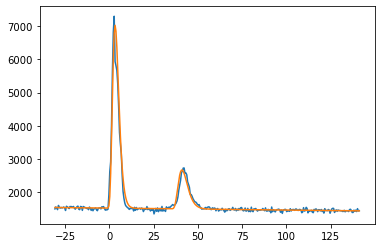

In [7]:
fig = lc.plot_fit()
ax = fig.gca()
# ax.set_xlim([-8,50])

#### Another way to set parameter values is to pass a list

In [8]:
lc.set_param_values([-3,5200,6.22,6,33,1173,8,4.5])

lc.all_parameters

{'FRED1': {'start': -3, 'scale': 5200, 'tau': 6.22, 'xi': 6},
 'FRED2': {'start': 6, 'scale': 33, 'tau': 1173, 'xi': 4.7}}

#### setup fit

In [9]:
param_names = ["start1", "scale1", "tau1", "start2", "scale2", "tau2"]
# param_names = ["start1", "scale1", "tau1", "xi1", "start2", "scale2", "tau2", "xi2"]

#### ReativeNestedSampler

In [10]:
res_name = f'bn{TriggNum}_2FRED_NL'

sampler = un.ReactiveNestedSampler(param_names, lc.log_likelihood, lc.prior_transform, resume='subfolder',
                                      log_dir=f'chains/{res_name}',num_test_samples=10,vectorized=False,
                                   draw_multiple=True)

Creating directory for new run chains/bn081009140_2FRED_NL/run6


In [20]:
results = sampler.run() #note that you have many options for .run(), such as frac_remain

[ultranest] Sampling 400 live points from prior ...


/usr/local/anaconda3/envs/afterglowpy/lib/python3.7/site-packages/ultranest/integrator.py:1622: UserWarning: Sampling from region seems inefficient (0/40 accepted in iteration 2500). To improve efficiency, modify the transformation so that the current live points (stored for you in chains/bn081009140_2FRED_NL/run5/extra/sampling-stuck-it%d.csv) are ellipsoidal, or use a stepsampler, or set frac_remain to a lower number (e.g., 0.5) to terminate earlier.
  warnings.warn(warning_message)


[ultranest] Explored until L=-2e+03  037.97 [-2038.3987..-2038.3984]*| it/evals=14385/143221 eff=10.0720% N=400 
[ultranest] Likelihood function evaluations: 143226
[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and results to disk ... done
[ultranest]   logZ = -2070 +- 0.1682
[ultranest] Effective samples strategy satisfied (ESS = 2573.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.35, need <0.5)
[ultranest]   logZ error budget: single: 0.27 bs:0.17 tail:0.01 total:0.17 required:<0.50
[ultranest] done iterating.


### Vectorised model

In case you want to significantly speed up the sampling when using e.g. ultranest, you can use the vectorised option by setting vectorised = True when initiating the LC_fit object. Note that you then might need to supply np.ndarrays instead of floats when setting parameter values for certain functions

### This is for NL scenario

{'FRED1': {'start': array([-3]),
  'scale': array([5500]),
  'tau': array([6.22]),
  'xi': array([6])},
 'FRED2': {'start': array([33]),
  'scale': array([1173]),
  'tau': array([8]),
  'xi': array([4.7])}}

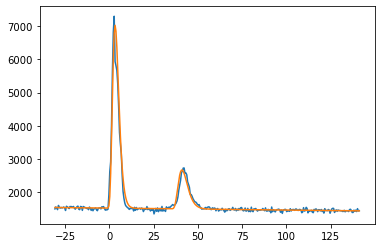

In [44]:
### Create LC fit object

lc = PF.LC_fit(x,y,bkg,vectorised=True)

lc.add_pulse_component('FRED1',rate_funcs.FRED_pulse)
lc.add_pulse_component('FRED2',rate_funcs.FRED_pulse)

#### set priros

TrianglePrior = PF.Prior_unit_cube('Triangle',{'P1':(-5,50),'P2':(50,50)})
lc.FRED1.start.set_prior(TrianglePrior)
lc.FRED1.scale.set_prior(PF.Prior_unit_cube('Log_Uniform',{'lo':1e3,'hi':1e4}))
lc.FRED1.tau.set_prior(PF.Prior_unit_cube('Log_Uniform',{'lo':1e0,'hi':1e1}))
lc.FRED1.xi.set_prior(PF.Prior_unit_cube('Log_Uniform',{'lo':1e0,'hi':1e1}))

lc.FRED2.start.set_prior(TrianglePrior)
lc.FRED2.scale.set_prior(PF.Prior_unit_cube('Log_Uniform',{'lo':1e3,'hi':1e4}))
lc.FRED2.tau.set_prior(PF.Prior_unit_cube('Log_Uniform',{'lo':1e0,'hi':1e1}))
lc.FRED2.xi.set_prior(PF.Prior_unit_cube('Log_Uniform',{'lo':1e0,'hi':1e1}))

#### initialize parameters

parvals1 = {'start': np.array([-3]), 'scale': np.array([5500]), 'tau': np.array([6.22]), 'xi':np.array([6])}
lc.FRED1.set_args(parvals1)
parvals2 = {'start': np.array([33]), 'scale': np.array([1173]), 'tau': np.array([8]), 'xi':np.array([4.7])}
lc.FRED2.set_args(parvals2)

# obs that this still works:
# parvals2 = {'start': 75, 'scale': 100, 'tau': 10, 'xi':4.7}
# lc.FRED2.set_args(parvals2)

fig = lc.plot_fit()

lc.all_parameters

#### Another way of setting parameters

In [45]:
lc.set_param_values(np.array([[-3,5500,6.22,6,33,1173,8,4.7]]))

# This no longer works once you have set the vectorised flag to True
# lc.set_param_values([-3,5500,6.22,6,33,1173,8,4.5])

lc.all_parameters

{'FRED1': {'start': array([-3.]),
  'scale': array([5500.]),
  'tau': array([6.22]),
  'xi': array([6.])},
 'FRED2': {'start': array([33.]),
  'scale': array([1173.]),
  'tau': array([8.]),
  'xi': array([4.7])}}

#### setup fit

In [47]:
param_names = ["start1", "scale1", "tau1", "xi1", "start2", "scale2", "tau2", "xi2"]

#### ReativeNestedSampler

In [49]:
res_name = f'bn{TriggNum}_2FRED_NL'

sampler = un.ReactiveNestedSampler(param_names, lc.log_likelihood, lc.prior_transform, resume='subfolder',
                                      log_dir=f'chains/{res_name}',num_test_samples=10,vectorized=True,
                                   draw_multiple=True)

Creating directory for new run chains/bn081009140_2FRED_NL/run3


In [50]:
results = sampler.run() #note that you have many options for .run(), such as frac_remain

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+03  037.84 [-2038.6438..-2038.6435]*| it/evals=16600/481383 eff=3.4513% N=400   
[ultranest] Likelihood function evaluations: 481548
[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and results to disk ... done
[ultranest]   logZ = -2075 +- 0.2001
[ultranest] Effective samples strategy satisfied (ESS = 3030.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.44, need <0.5)
[ultranest]   logZ error budget: single: 0.29 bs:0.20 tail:0.01 total:0.20 required:<0.50
[ultranest] done iterating.


### These are some plotting options

#### Using the third party package corner

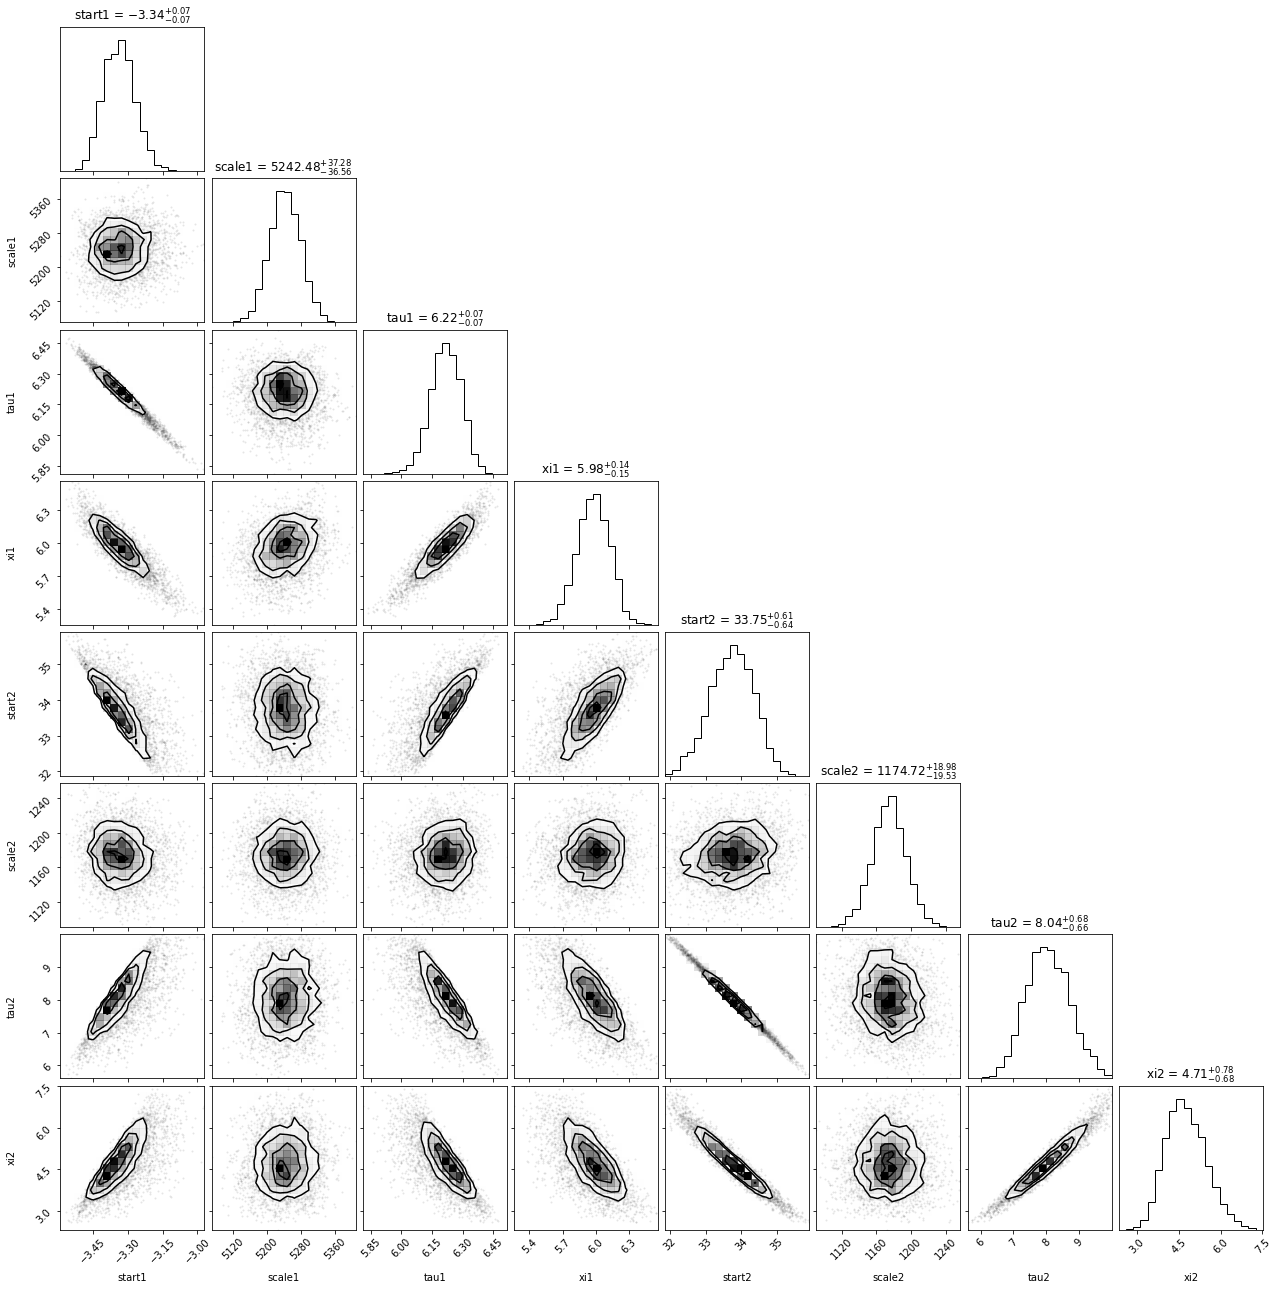

In [51]:
fig = lc.plot_corner(results, param_names, show_title = True)

#### Using the third party package chainconsumer

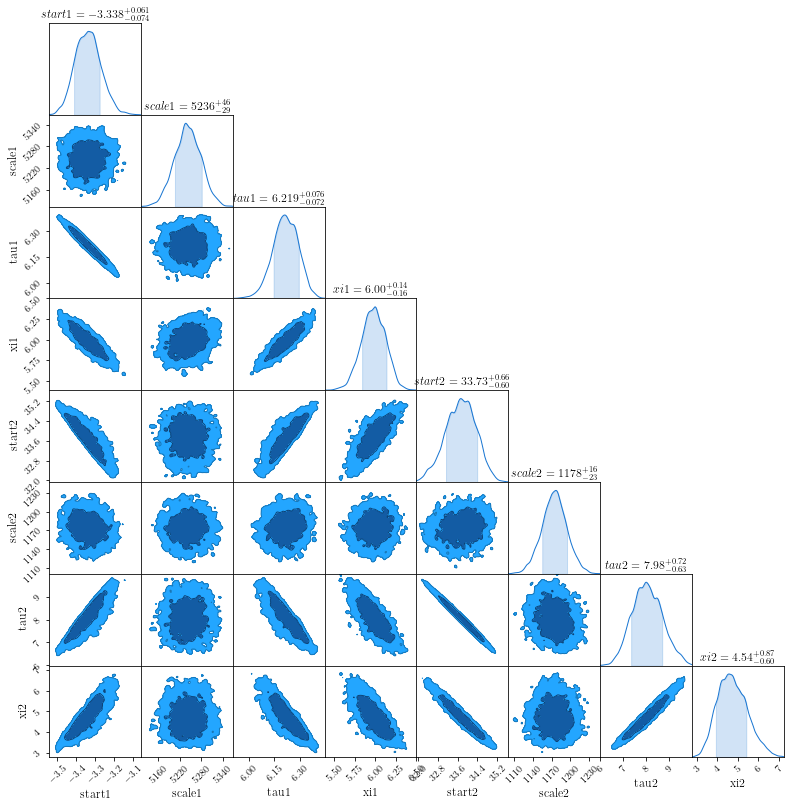

In [52]:
fig = lc.plot_corner_cc(results, param_names)

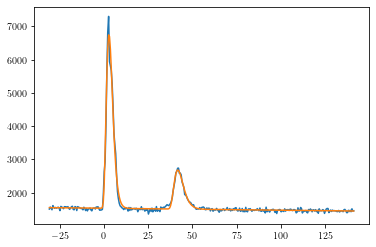

In [53]:
param_values = results['posterior']['mean']
pval = np.array([param_values])

fig = lc.plot_fit(param_values = pval)

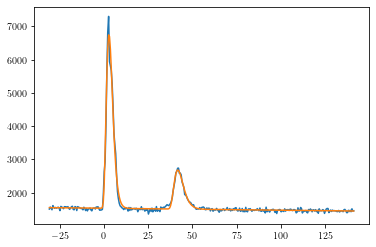

In [54]:
fig = lc.plot_fit(results = results)

### Modifying functions

In case you want to make some functions share parameters, you can do that by assigning the parameters from one function to the corresponding parameter in another function. These are then the same. Note that you must assign the entire parameter instance, and not just its value. This works the same for the vectorised and non-vectorised case.

{'FRED1': {'start': array([-3]), 'scale': array([5500]), 'tau': array([6.22]), 'xi': array([6])}, 'FRED2': {'start': array([35]), 'scale': array([1173]), 'tau': array([6.22]), 'xi': array([6])}}
{'FRED1': ['start', 'scale', 'tau', 'xi'], 'FRED2': ['start', 'scale']}


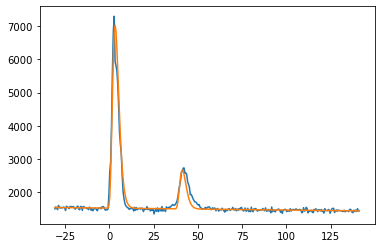

In [5]:
### Create LC fit object

lc = PF.LC_fit(x,y,bkg,vectorised=True)

lc.add_pulse_component('FRED1',rate_funcs.FRED_pulse)
lc.add_pulse_component('FRED2',rate_funcs.FRED_pulse)

#### set priros

TrianglePrior = PF.Prior_unit_cube('Triangle',{'P1':(-5,50),'P2':(50,50)})
lc.FRED1.start.set_prior(TrianglePrior)
lc.FRED1.scale.set_prior(PF.Prior_unit_cube('Log_Uniform',{'lo':1e3,'hi':1e4}))
lc.FRED1.tau.set_prior(PF.Prior_unit_cube('Log_Uniform',{'lo':1e0,'hi':1e1}))
lc.FRED1.xi.set_prior(PF.Prior_unit_cube('Log_Uniform',{'lo':1e0,'hi':1e1}))

lc.FRED2.start.set_prior(TrianglePrior)
lc.FRED2.scale.set_prior(PF.Prior_unit_cube('Log_Uniform',{'lo':1e3,'hi':1e4}))
lc.FRED2.tau = lc.FRED1.tau
lc.FRED2.xi = lc.FRED1.xi

# #### initialize parameters

parvals1 = {'start': np.array([-3]), 'scale': np.array([5500]), 'tau': np.array([6.22]), 'xi':np.array([6])}
lc.FRED1.set_args(parvals1)
parvals2 = {'start': np.array([35]), 'scale': np.array([1173])}
lc.FRED2.set_args(parvals2)

fig = lc.plot_fit()

print(lc.all_parameters)
print(lc.free_parameters)

##### Note also
that the attributes .free_parameters (in the function instances and the LC_fit instance) are constructed such that each parameter show up only once

#### setup fit

In [6]:
param_names = ["start1", "scale1", "tau1", "xi1", "start2", "scale2"] #here tau2, xi2 have been removed, since they are now given by tau1 and xi1

#### ReativeNestedSampler

In [7]:
res_name = f'bn{sbo.TriggNum}_2FRED_L'

sampler = un.ReactiveNestedSampler(param_names, lc.log_likelihood, lc.prior_transform, resume='subfolder',
                                      log_dir=f'chains/{res_name}',num_test_samples=10,vectorized=True,
                                   draw_multiple=True)

Creating directory for new run chains/bn081009140_2FRED_L/run3


In [1066]:
start_1 = time.time()
results = sampler.run(frac_remain=0.1)
end_1 = time.time()
print(end_1 - start_1)

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+03  221.78 [-2222.9622..-2222.9621]*| it/evals=13640/267261 eff=5.1113% N=400  0 
[ultranest] Likelihood function evaluations: 267443
[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and results to disk ... done
[ultranest]   logZ = -2254 +- 0.2012
[ultranest] Effective samples strategy satisfied (ESS = 2677.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.47, need <0.5)
[ultranest]   logZ error budget: single: 0.27 bs:0.20 tail:0.10 total:0.22 required:<0.50
[ultranest] done iterating.
51.020211935043335


### You can also sample using e.g. Emcee

In [60]:
import emcee

#### You then need to use the non-vectorised version

{'FRED1': {'start': -3, 'scale': 5500, 'tau': 6.22, 'xi': 6}, 'FRED2': {'start': 36, 'scale': 1173, 'tau': 6.22, 'xi': 6}}
{'FRED1': ['start', 'scale', 'tau', 'xi'], 'FRED2': ['start', 'scale']}


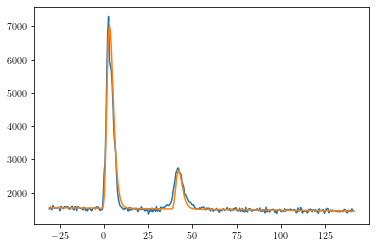

In [74]:
### Create LC fit object

lc = PF.LC_fit(x,y,bkg,vectorised=False)

lc.add_pulse_component('FRED1',rate_funcs.FRED_pulse)
lc.add_pulse_component('FRED2',rate_funcs.FRED_pulse)

#### set priros

TrianglePrior = PF.Prior_unit_cube('Triangle',{'P1':(-5,50),'P2':(50,50)})
lc.FRED1.start.set_prior(TrianglePrior)
lc.FRED1.scale.set_prior(PF.Prior_unit_cube('Log_Uniform',{'lo':1e3,'hi':1e4}))
lc.FRED1.tau.set_prior(PF.Prior_unit_cube('Log_Uniform',{'lo':1e0,'hi':1e1}))
lc.FRED1.xi.set_prior(PF.Prior_unit_cube('Log_Uniform',{'lo':1e0,'hi':1e1}))

lc.FRED2.start.set_prior(TrianglePrior)
lc.FRED2.scale.set_prior(PF.Prior_unit_cube('Log_Uniform',{'lo':1e3,'hi':1e4}))
lc.FRED2.tau = lc.FRED1.tau
lc.FRED2.xi = lc.FRED1.xi

# #### initialize parameters

parvals1 = {'start': -3, 'scale': 5500, 'tau': 6.22, 'xi':6}
lc.FRED1.set_args(parvals1)
parvals2 = {'start': 36, 'scale': 1173}
lc.FRED2.set_args(parvals2)

fig = lc.plot_fit()

print(lc.all_parameters)
print(lc.free_parameters)

In [75]:
pos = np.array([-3,5500,8,6,33,1173]) + 1e-4 * np.random.randn(32, 6)

nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, lc.log_likelihood)
sampler.run_mcmc(pos, 30000, progress=True);

100%|██████████| 30000/30000 [02:27<00:00, 203.89it/s]


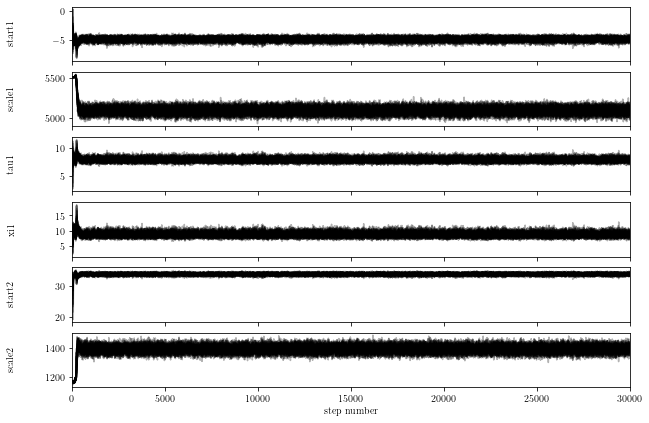

In [77]:
fig, axes = plt.subplots(6, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["start1", "scale1", "tau1", "xi1", "start2", "scale2"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [78]:
tau = sampler.get_autocorr_time()
print(tau)

[ 64.60801361 202.58326018  75.6190935   71.16450035  83.76694896
 150.51096995]


In [79]:
flat_samples = sampler.get_chain(discard=100, thin=50, flat=True)
print(flat_samples.shape)

(19136, 6)


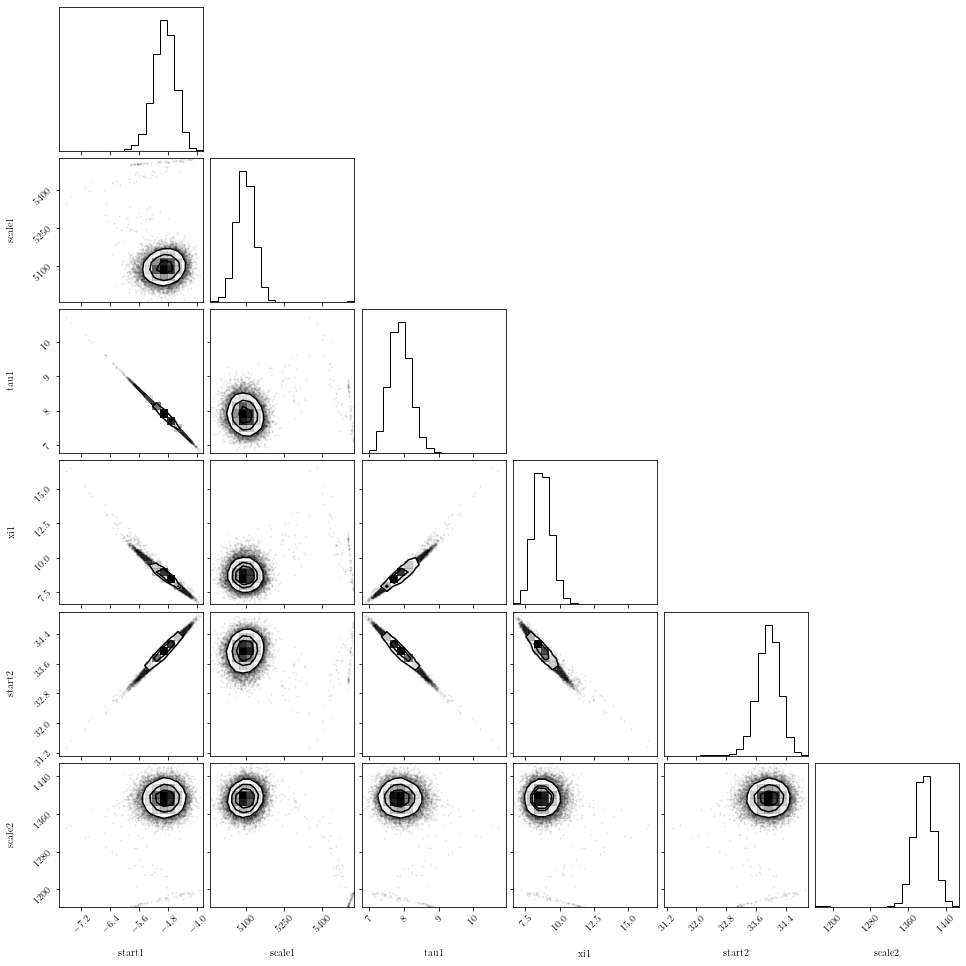

In [80]:
fig = corner.corner(
    flat_samples, labels=labels);

### You can also perform maximum likelihood fits using e.g. scipy's built in minimiser

In [88]:
### Create LC fit object

lc = PF.LC_fit(x,y,bkg,vectorised=False)

lc.add_pulse_component('FRED1',rate_funcs.FRED_pulse)
lc.add_pulse_component('FRED2',rate_funcs.FRED_pulse)

#### set priros

TrianglePrior = PF.Prior_unit_cube('Triangle',{'P1':(-5,50),'P2':(50,50)})
lc.FRED1.start.set_prior(TrianglePrior)
lc.FRED1.scale.set_prior(PF.Prior_unit_cube('Log_Uniform',{'lo':1e3,'hi':1e4}))
lc.FRED1.tau.set_prior(PF.Prior_unit_cube('Log_Uniform',{'lo':1e0,'hi':1e1}))
lc.FRED1.xi.set_prior(PF.Prior_unit_cube('Log_Uniform',{'lo':1e0,'hi':1e1}))

lc.FRED2.start.set_prior(TrianglePrior)
lc.FRED2.scale.set_prior(PF.Prior_unit_cube('Log_Uniform',{'lo':1e3,'hi':1e4}))
lc.FRED2.tau = lc.FRED1.tau
lc.FRED2.xi = lc.FRED1.xi


In [89]:
minfun = lambda x:-lc.log_likelihood(x)

In [99]:
x0 = np.array([-3,5500,6.22,6,33,1173])
x1 = np.random.rand(8)
res = minimize(minfun, x0)

In [100]:
res

      fun: 2206.2070587332983
 hess_inv: array([[ 0.02776723, -0.18039802, -0.02911292, -0.06056873,  0.02777383,
         0.28967243],
       [-0.18039802, 23.1964587 ,  0.18965786,  0.44168751, -0.17705582,
        -8.01082644],
       [-0.02911292,  0.18965786,  0.03068531,  0.06394281, -0.02927993,
        -0.30511826],
       [-0.06056873,  0.44168751,  0.06394281,  0.13645733, -0.06115514,
        -0.66219494],
       [ 0.02777383, -0.17705582, -0.02927993, -0.06115514,  0.02954253,
         0.28844939],
       [ 0.28967243, -8.01082644, -0.30511826, -0.66219494,  0.28844939,
         5.65433227]])
      jac: array([ 0.00012207, -0.00036621,  0.01000977, -0.00146484,  0.00476074,
        0.        ])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 698
      nit: 49
     njev: 98
   status: 2
  success: False
        x: array([-4.85396134e+00,  5.09445198e+03,  7.82926530e+00,  8.61896382e+00,
        3.39924342e+01,  1.39306418e+03])

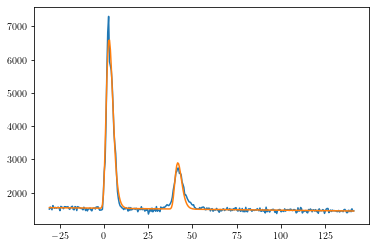

In [101]:
fig = lc.plot_fit()

#### If you want to plot contours

In [113]:
tau = np.logspace(0.2,1.2,100)
xi = np.logspace(-0.5,1.6,100)

X, Y = np.meshgrid(tau, xi)
Z = np.zeros(X.shape)

for i in range(len(tau)):
    for j in range(len(xi)):
        x0 = np.array([-3,5500,tau[j],xi[i],35,1173])
        Z[i,j] = -lc.log_likelihood(x0)

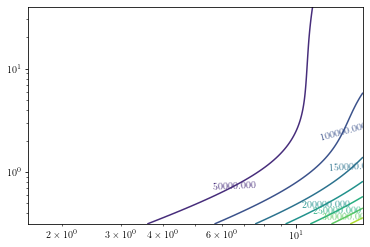

In [114]:
fig, ax = plt.subplots()
CS = ax.contour(X, Y, Z)
ax.clabel(CS, inline=False, fontsize=10)
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim([0.1,10])
# ax.set_xlim([30,40])


### Plot priors
In case you want to check the prior distributions

In [ ]:
cube = np.random.rand(6,100000).T
samples = []
for c in cube:
    samples.append(lc.prior_transform(c))
samples = np.array(samples)
fig = corner.corner(samples,labels=param_names)